# Kmeans Clustering


## 1. Do kmeans clustering and show on mds data

In [1]:
import kmeansClustering_functions as kmc
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import math
import df_manipulation_functions as dfmf


In [2]:

#from pickle file
basic_features = pd.read_pickle('Flow_Features/basic_features_flow.pkl')
additional_features = pd.read_pickle('Flow_Features/additional_features_flow.pkl')
all_features = pd.read_pickle('Flow_Features/all_features_flow.pkl')



basic_features_normalized = dfmf.normalize_data(basic_features)
additional_features_normalized = dfmf.normalize_data(additional_features)
all_features_normalized = dfmf.normalize_data(all_features)

# basic_features_normalized = dfmf.force_normalize_data(basic_features)
# additional_features_normalized = dfmf.force_normalize_data(additional_features)
# all_features_normalized = dfmf.force_normalize_data(all_features)

lower_bound = 2
num_clusters = 70

cluster_labels_kmeans_basic , cluster_scores_kmeans_basic= kmc.kmeans_clustering(all_features,basic_features_normalized, lower_bound, num_clusters)
cluster_labels_kmeans_additional, cluster_scores_kmeans_additional = kmc.kmeans_clustering(all_features, additional_features_normalized, lower_bound, num_clusters)
cluster_labels_kmeans_all, cluster_scores_kmeans_all = kmc.kmeans_clustering(all_features, all_features_normalized, lower_bound, num_clusters)

#save the cluster labels to a csv file in the current directory
cluster_labels_kmeans_basic.to_csv('Labels/Kmeans/cluster_labels_kmeans_basic_flow.csv')
#save the cluster scores to a csv file
cluster_scores_kmeans_basic.to_csv('Scores/Kmeans/cluster_scores_kmeans_basic_flow.csv')

#save the additional cluster labels to a csv file 
cluster_labels_kmeans_additional.to_csv('Labels/Kmeans/cluster_labels_kmeans_additional_flow.csv')
#save the additional cluster scores to a csv file
cluster_scores_kmeans_additional.to_csv('Scores/Kmeans/cluster_scores_kmeans_additional_flow.csv')

#save the cluster labels to a csv file
cluster_labels_kmeans_all.to_csv('Labels/Kmeans/cluster_labels_kmeans_additional_flow.csv')
#save the cluster scores to a csv file
cluster_scores_kmeans_all.to_csv('Scores/Kmeans/cluster_scores_kmeans_additional_flow.csv')


In [3]:
all_features_normalized.head()


,mean,std,min,max,median,range,time_above_average,similarity_to_mean_year,number_of_peaks,min_slope_5,...,day_downward_crossing_high_quartile_cos,day_downward_crossing_low_quartile_sin,day_downward_crossing_low_quartile_cos,day_upward_crossing_low_quartile_sin,day_upward_crossing_low_quartile_cos,day_first_downward_crossing_mean_sin,day_first_downward_crossing_mean_cos,day_of_min_sin,day_of_min_cos,Stationsnummer
0,0.443824,0.680325,0.302248,0.500930,0.361726,0.630498,-0.158940,-0.078508,-0.234375,-0.509596,...,-0.504961,-0.951057,0.309017,0.845249,-0.534373,-0.999546,-0.030120,0.068802,0.997630,2009.0
1,0.774938,0.463137,0.880325,0.680507,0.816754,0.496357,-0.079470,0.128101,-0.117188,-0.458871,...,-0.999667,-0.930724,-0.365723,-0.120208,0.992749,-0.845249,-0.534373,-0.432776,0.901502,2016.0
2,0.319595,0.491474,0.251262,0.374975,0.310785,0.451318,-0.066225,0.059500,-0.390625,-0.427858,...,-0.890028,-0.987349,0.158559,0.991114,-0.133015,-0.988678,-0.150055,0.508671,0.860961,2018.0
3,0.053411,0.128825,0.026102,0.069086,0.045236,0.094291,0.000000,-0.034757,-0.195313,-0.031867,...,-0.381689,-0.914128,0.405426,0.924291,-0.381689,-0.997325,0.073095,0.085965,0.996298,2019.0
4,0.565321,0.422146,0.617699,0.520100,0.551097,0.420569,0.026490,0.150550,-0.312500,-0.357374,...,-0.999667,-0.967938,-0.251190,0.998880,-0.047321,-0.930724,-0.365723,0.858764,0.512371,2029.0


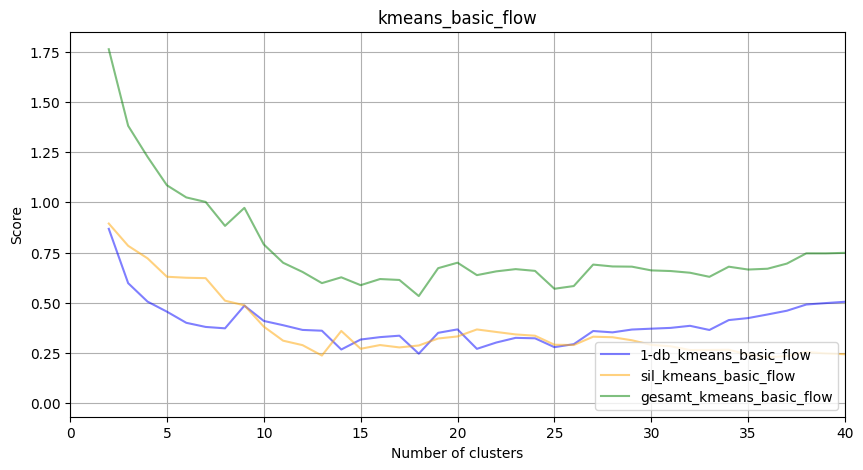

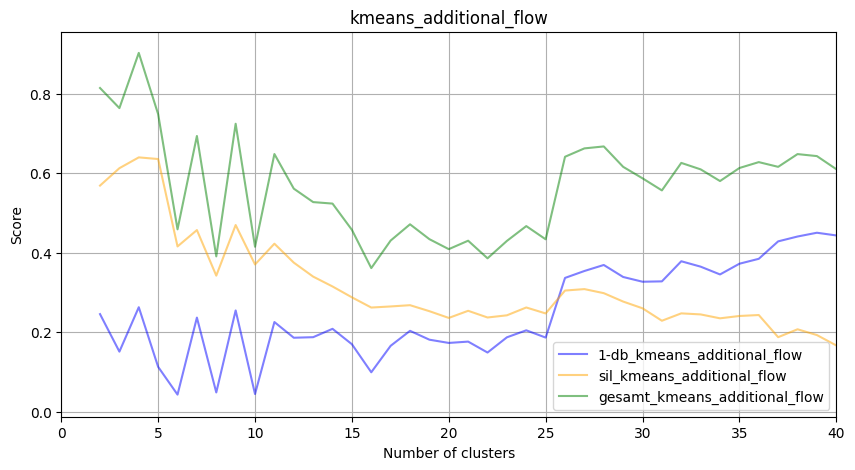

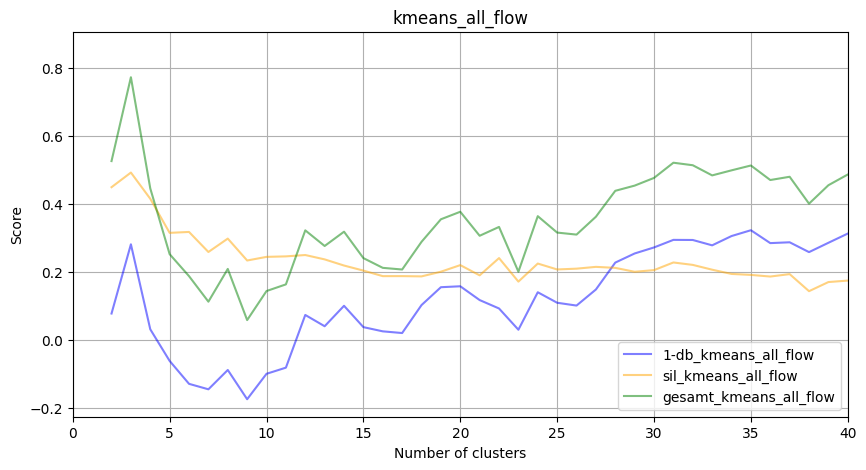

In [4]:
from matplotlib import ticker


def plot_scores(cluster_scores, cluster_option):

    

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(cluster_scores['num_clusters'], 1-cluster_scores['davies_bouldin_score'], label='1-db_' + cluster_option, color='blue')
    ax.plot(cluster_scores['num_clusters'], cluster_scores['silhouette_score'], label='sil_' +  cluster_option, color='orange')
    ax.plot(cluster_scores['num_clusters'], -cluster_scores['davies_bouldin_score']+ 1 + cluster_scores['silhouette_score'], label='gesamt_' + cluster_option, color='green')
    ax.grid(True, which='both')
    #reduce x axis to0 to 20
    ax.set_xlim(0,40)

    #only show points not lines
    
      
    ax.set_title(cluster_option)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Score')
    #make graphs semi transparent
    for line in ax.get_lines():
        line.set_alpha(0.5)

    #show the legend in the lower right corner
    ax.legend(loc = 'lower right')
    plt.show()


plot_scores(cluster_scores_kmeans_basic, 'kmeans_basic_flow')
plot_scores(cluster_scores_kmeans_additional, 'kmeans_additional_flow')
plot_scores(cluster_scores_kmeans_all, 'kmeans_all_flow')




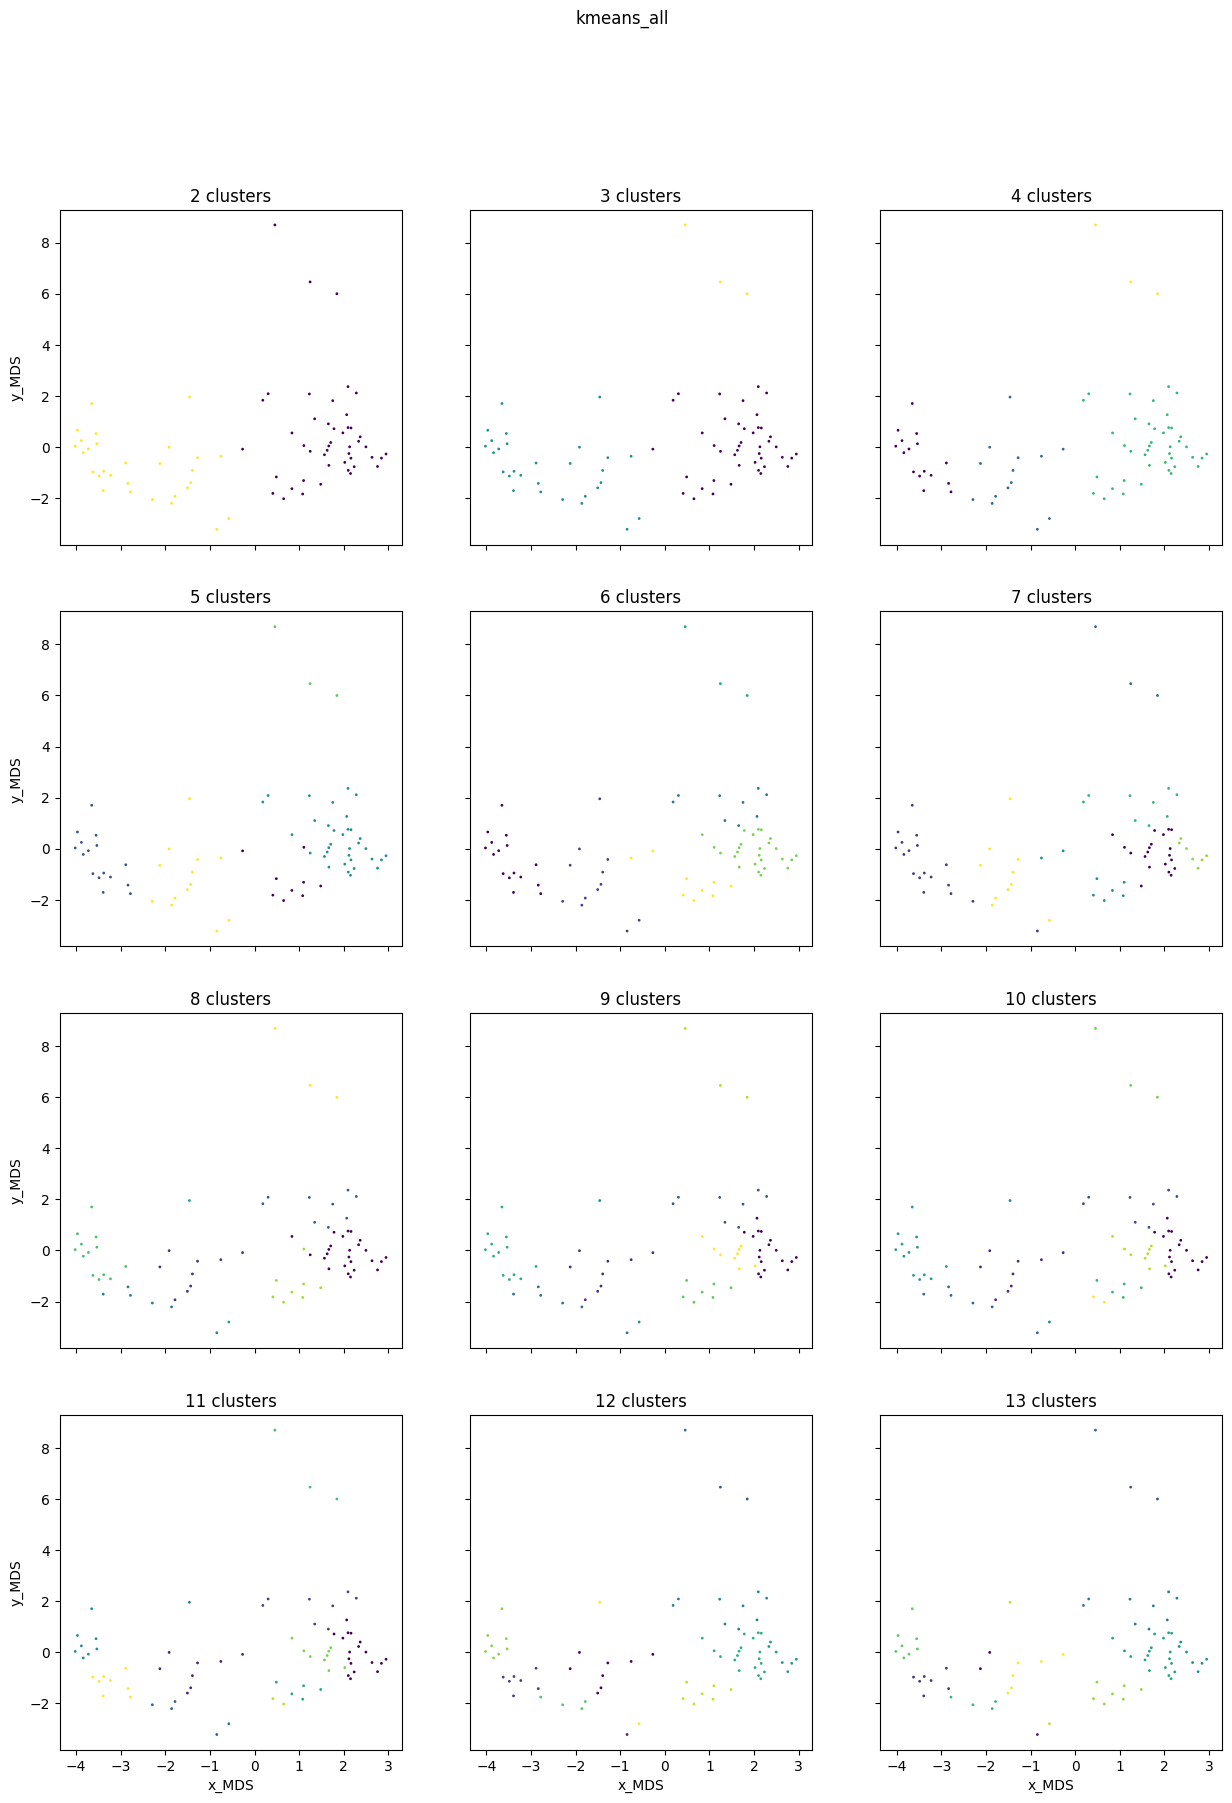

In [5]:
def plot_clusters(number_of_plots, num_columns, lower_bound, mds_representation, cluster_labels, name):
    # plot the clusters
    num_rows = math.ceil(number_of_plots/num_columns) 
    j = 0
    i = 0

    current_cluster = lower_bound
   


    fig, axs = plt.subplots(num_rows, num_columns)
    fig.set_size_inches(15,20)
    fig.suptitle(name)
    while current_cluster < number_of_plots + lower_bound:
        axs[j,i].scatter(mds_representation['x_MDS'] , mds_representation['y_MDS'],s = 1, c=cluster_labels[str(current_cluster) + ' clusters'])
        axs[j,i].set_title(str(current_cluster) + ' clusters')
        #set the height of the subplots to be the same as the width
        #axs[j,i].set_aspect('equal')
        i = i+1
        if(i % 3 ==0):
            j = j+1
            i = 0
        current_cluster = current_cluster + 1

    for ax in axs.flat:
        ax.set(xlabel='x_MDS', ylabel='y_MDS')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

all_mds_all_df = pd.read_pickle('Flow_mds/all_features_mds_flow.pkl')

plot_clusters(12,3,2, all_mds_all_df, cluster_labels_kmeans_all, 'kmeans_all')

,time_above_average,similarity_to_mean_year,number_of_peaks,min_slope_5,max_slope_5,day_of_max,day_of_min,day_first_upward_crossing_mean,day_first_downward_crossing_mean,day_first_upward_crossing_high_quartile,day_downward_crossing_high_quartile,day_downward_crossing_low_quartile,day_upward_crossing_low_quartile,Stationsnummer
0,-0.158940,-0.078508,-0.234375,-0.509596,0.639933,190.0,4.0,133.0,272.0,156.0,243.0,292.0,124.0,2009.0
1,-0.079470,0.128101,-0.117188,-0.458871,0.829306,167.0,339.0,96.0,241.0,138.0,181.0,252.0,358.0,2016.0
2,-0.066225,0.059500,-0.390625,-0.427858,0.316256,170.0,31.0,119.0,265.0,147.0,210.0,283.0,99.0,2018.0
3,0.000000,-0.034757,-0.195313,-0.031867,0.091923,197.0,5.0,127.0,278.0,157.0,251.0,298.0,114.0,2019.0
4,0.026490,0.150550,-0.312500,-0.357374,0.536213,167.0,60.0,99.0,252.0,138.0,184.0,259.0,94.0,2029.0


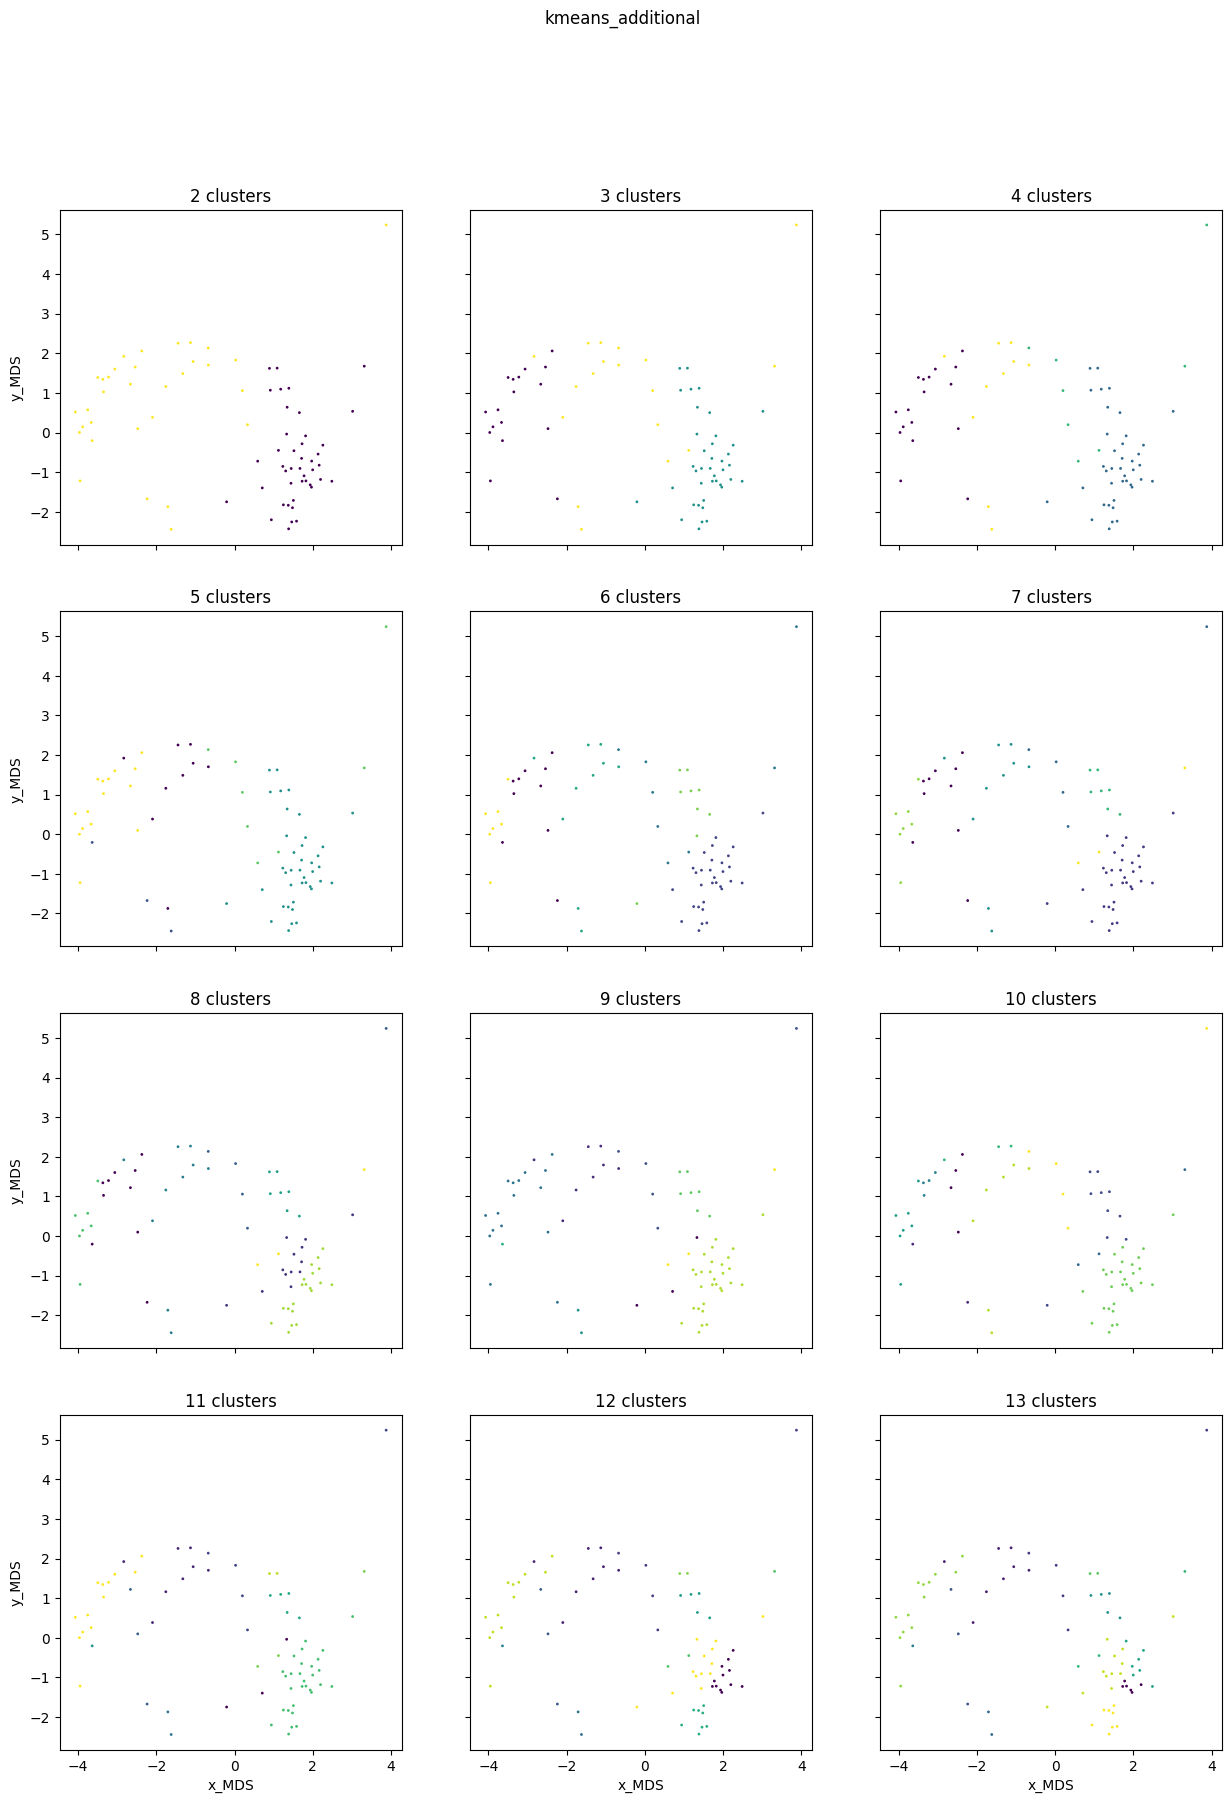

In [6]:
additional_mds = pd.read_pickle('Flow_mds/additional_features_mds_flow.pkl')
plot_clusters(12,3,2, additional_mds, cluster_labels_kmeans_additional, 'kmeans_additional')

additional_features_normalized.head()

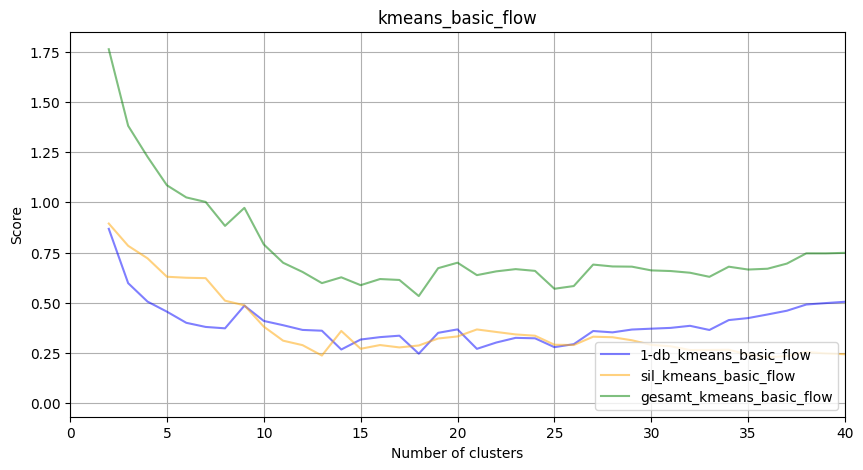

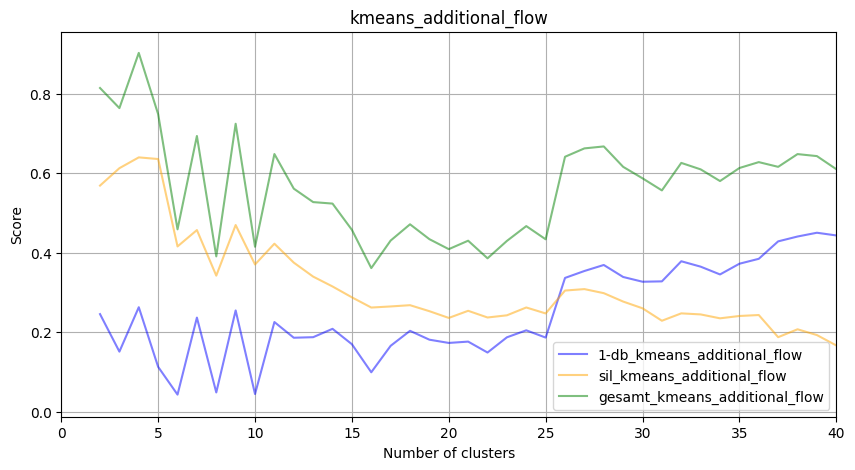

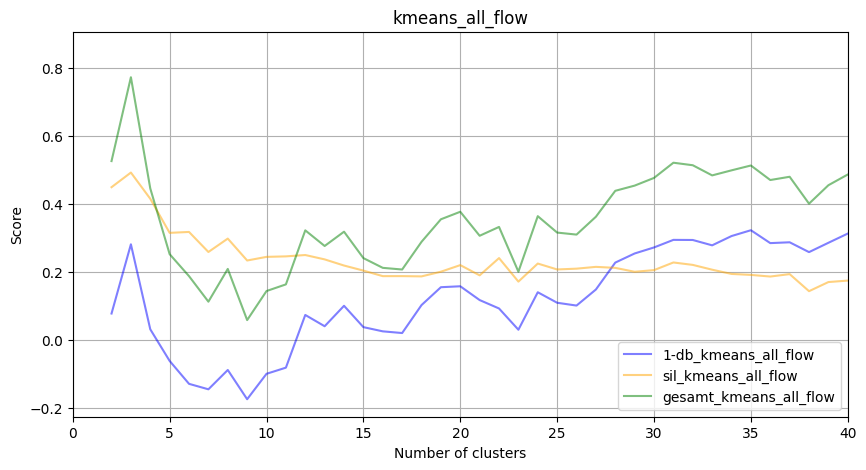

In [7]:
from matplotlib import ticker


def plot_scores(cluster_scores, cluster_option):

    

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(cluster_scores['num_clusters'], 1-cluster_scores['davies_bouldin_score'], label='1-db_' + cluster_option, color='blue')
    ax.plot(cluster_scores['num_clusters'], cluster_scores['silhouette_score'], label='sil_' +  cluster_option, color='orange')
    ax.plot(cluster_scores['num_clusters'], -cluster_scores['davies_bouldin_score']+ 1 + cluster_scores['silhouette_score'], label='gesamt_' + cluster_option, color='green')
    ax.grid(True, which='both')
    #reduce x axis to0 to 20
    ax.set_xlim(0,40)

    #only show points not lines
    
      
    ax.set_title(cluster_option)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Score')
    #make graphs semi transparent
    for line in ax.get_lines():
        line.set_alpha(0.5)

    #show the legend in the lower right corner
    ax.legend(loc = 'lower right')
    plt.show()


plot_scores(cluster_scores_kmeans_basic, 'kmeans_basic_flow')
plot_scores(cluster_scores_kmeans_additional, 'kmeans_additional_flow')
plot_scores(cluster_scores_kmeans_all, 'kmeans_all_flow')




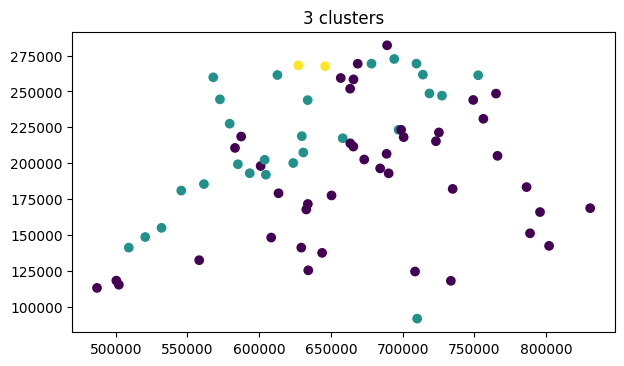

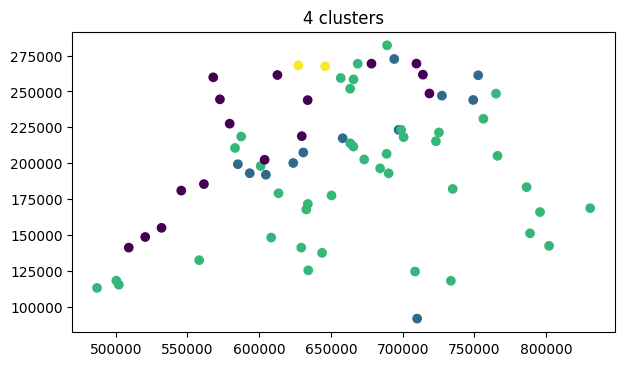

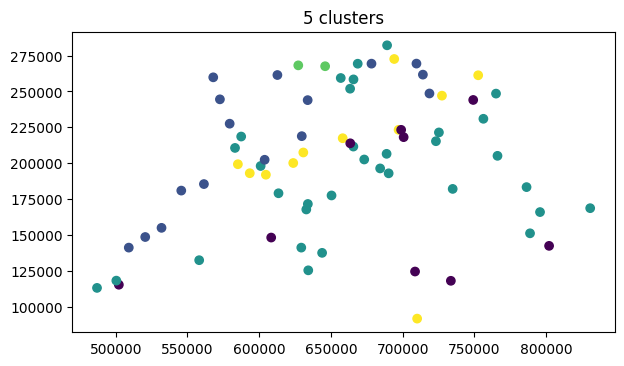

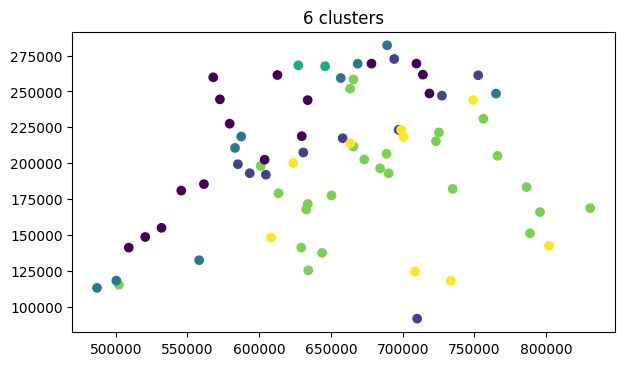

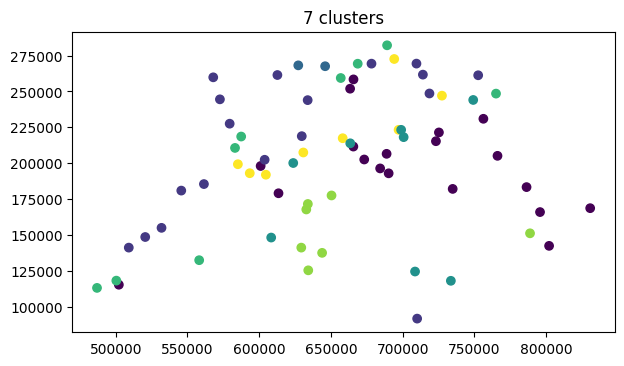

In [8]:
# show clusters on map 
#read in the data
locations_df = pd.read_csv("Data/stations_location.csv", sep=",")
#merge cluster labels with locations_df on Stationsnummer= Station_Nr
def merge_clusterlabels_map(cluster_labels):
    cluster_labels = pd.merge(cluster_labels, locations_df, left_on='Stationsnummer', right_on='Station_Nr')
    return cluster_labels
#plot the clusters with the locations of the stations

def plot_clusters_map( cluster_labels, num_clusters):

    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(cluster_labels['From_Node_X'] , cluster_labels['From_Node_Y'], c=cluster_labels[num_clusters + ' clusters'])
    ax.set_title(num_clusters +' clusters')
    ax.set_aspect('equal')
    #print name of each station to the point
    # for i, txt in enumerate(cluster_labels_kmeans_map['Station_Name']):
    #     ax.annotate(txt, (cluster_labels_kmeans_map['From_Node_X'][i], cluster_labels_kmeans_map['From_Node_Y'][i]))
    plt.show()

for i in range(3,8):
    plot_clusters_map(merge_clusterlabels_map(cluster_labels_kmeans_all), str(i))




c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-window+1:].append(daily_averaged_data)
c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-window+1:].append(daily_averaged_data)
c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-w

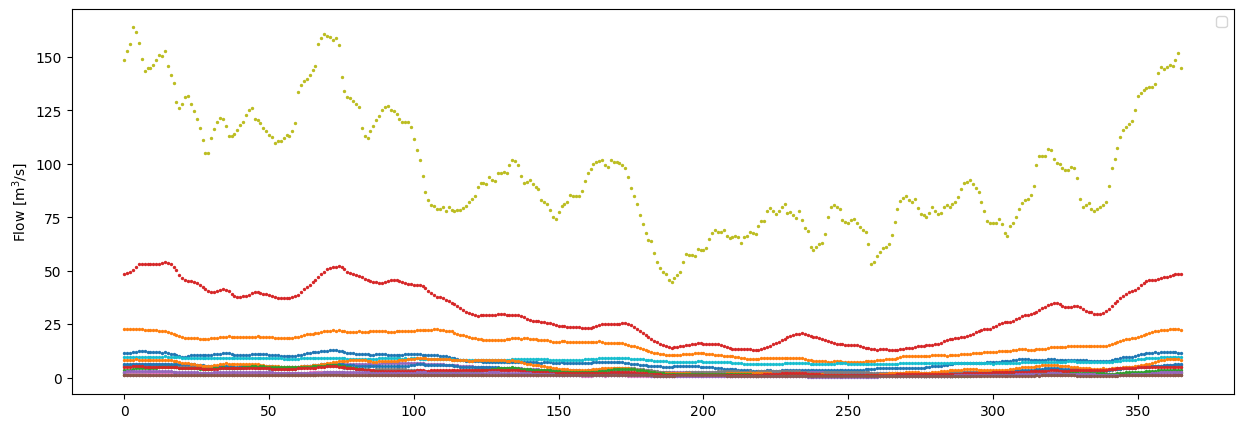

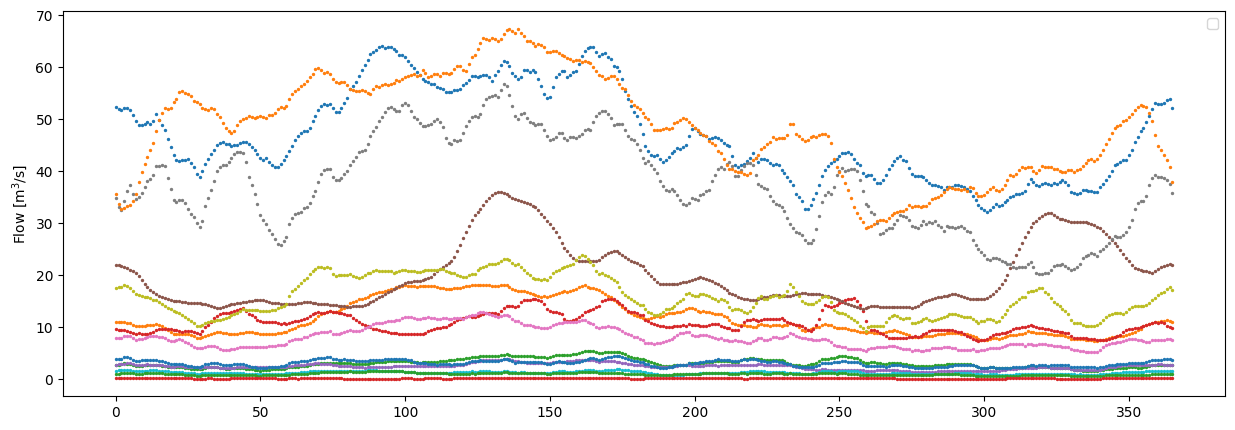

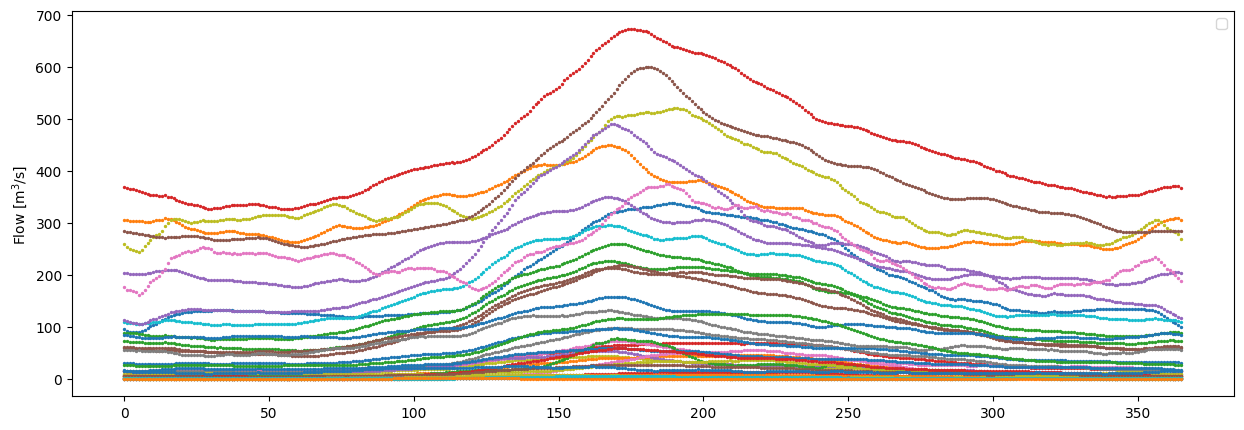

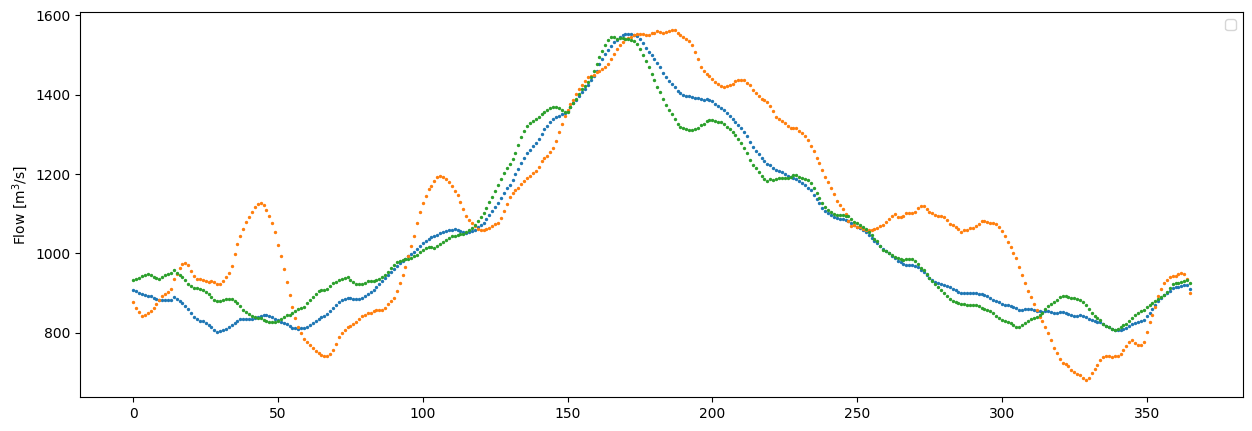

In [9]:
# plot all the stations flow data belonging to one cluster in one plot for 8 as number of cluste
import df_manipulation_functions as dfmf

num_clusters_plot = 4
flow_temp_df = pd.read_pickle("Data/flow_temp_df.pkl")

cluster_labels_kmeans_all.head()

for i in range(0,num_clusters_plot):
    belonging_to_cluster = cluster_labels_kmeans_all[cluster_labels_kmeans_all[str(num_clusters_plot) + ' clusters'] == i]
    station_numbers = belonging_to_cluster['Stationsnummer']
    labels = list()
    plt.figure(figsize=(15,5))
    #set scale of y axis to be the same for all plots
    for station in station_numbers:
        station_data = dfmf.get_running_mean_df(station, 15, flow_temp_df, 'Flow_Wert')
        plt.scatter(station_data.index, station_data['Flow_Wert'], s=2)
        station_data['mean'] = station_data['Flow_Wert'].mean()
        #plt.plot(station_data.index, station_data['mean'])
        #add to each curve the number and name of the station
    #     station_name = flow_temp_df.loc[flow_temp_df['Stationsnummer'] == station]['Stationsname'].unique()[0]
    #     labels.append(str(station)+ " " + station_name)       
    # plt.xlabel('Day of the year')
    plt.ylabel('Flow [m$^3$/s]')
    plt.legend(labels)

c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-window+1:].append(daily_averaged_data)
c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-window+1:].append(daily_averaged_data)
c:\Users\janzu\OneDrive - Universitaet Bern\Documents\GitHub\Clustering-of-Hydrological-Stations\df_manipulation_functions.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_data = daily_averaged_data.iloc[-w

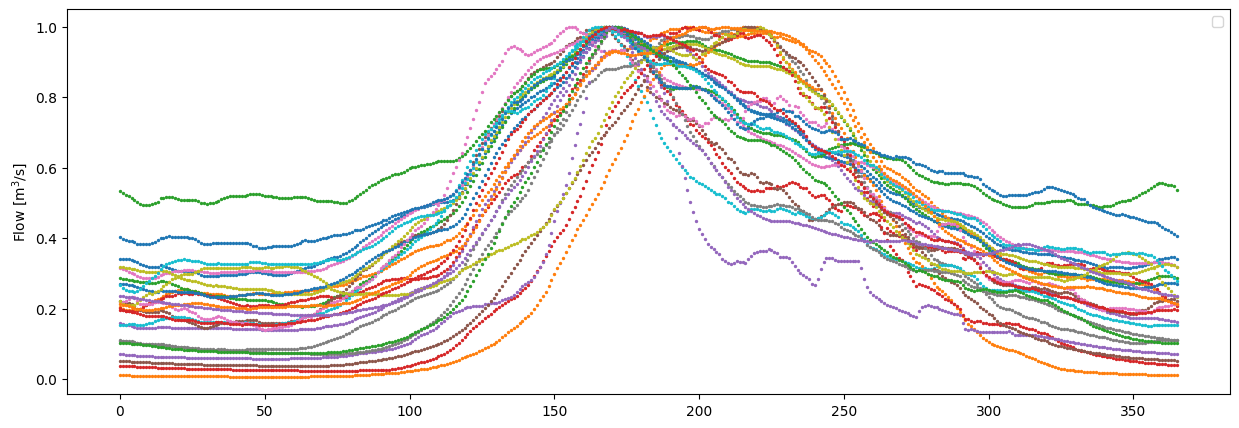

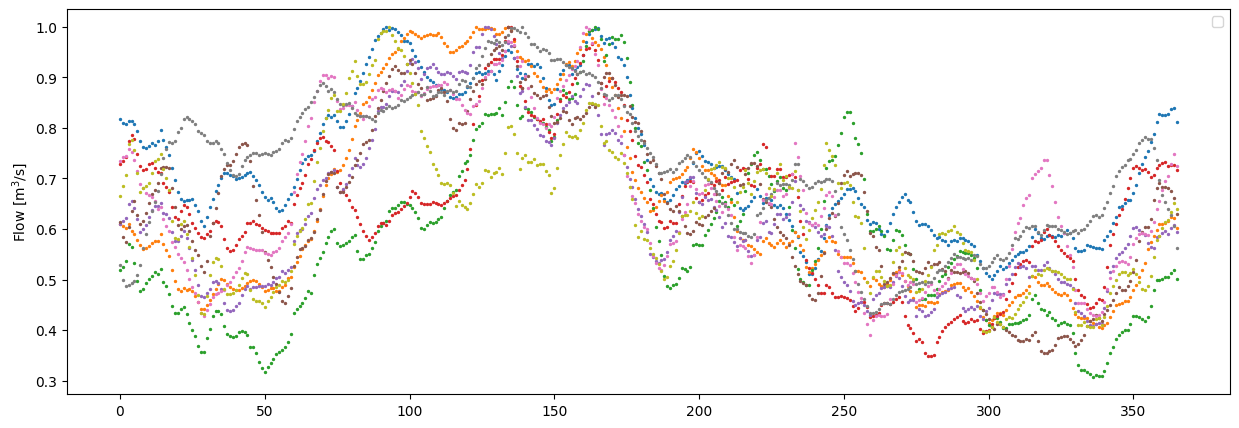

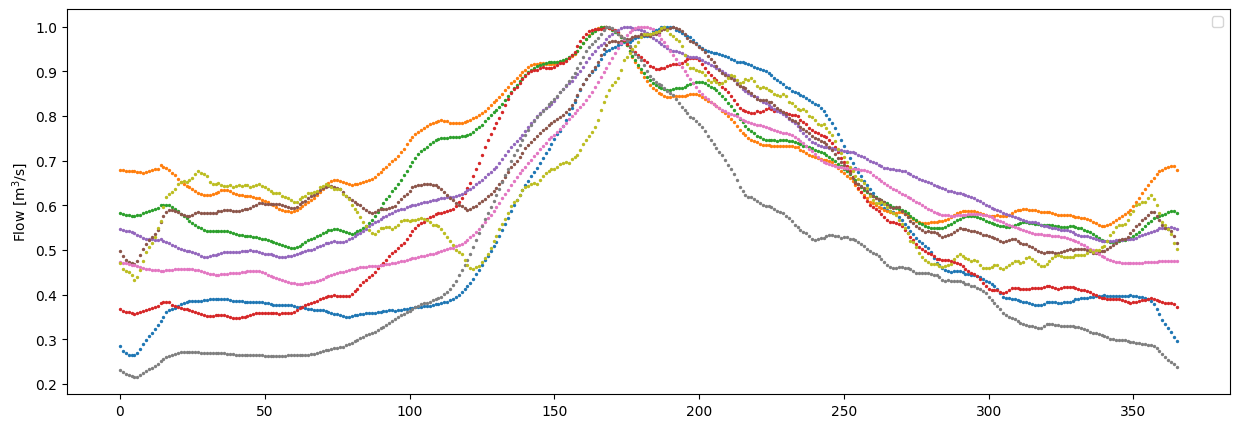

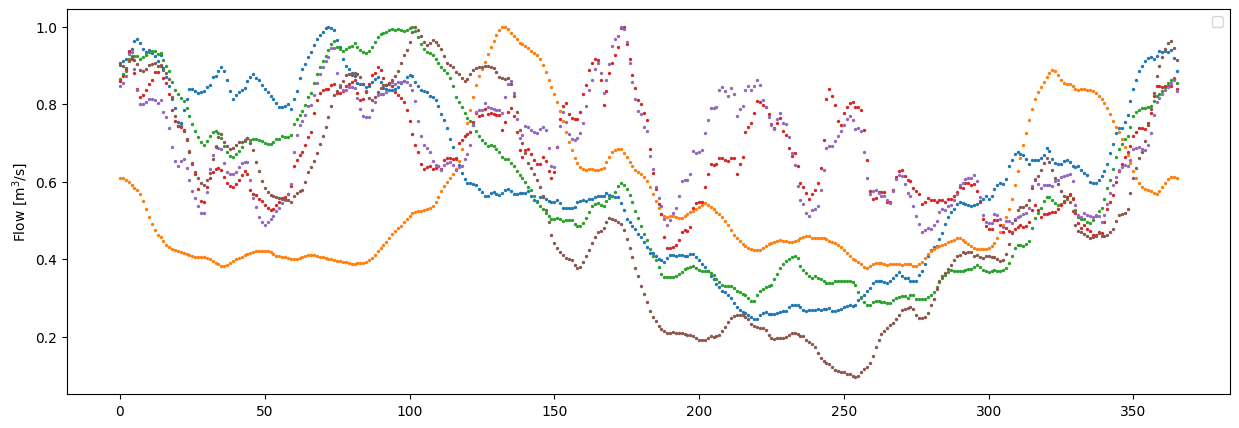

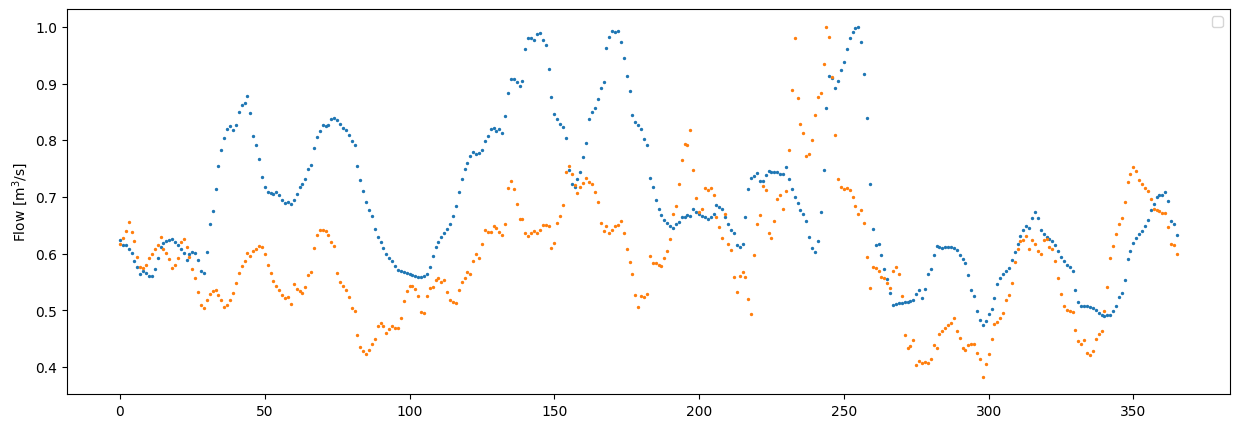

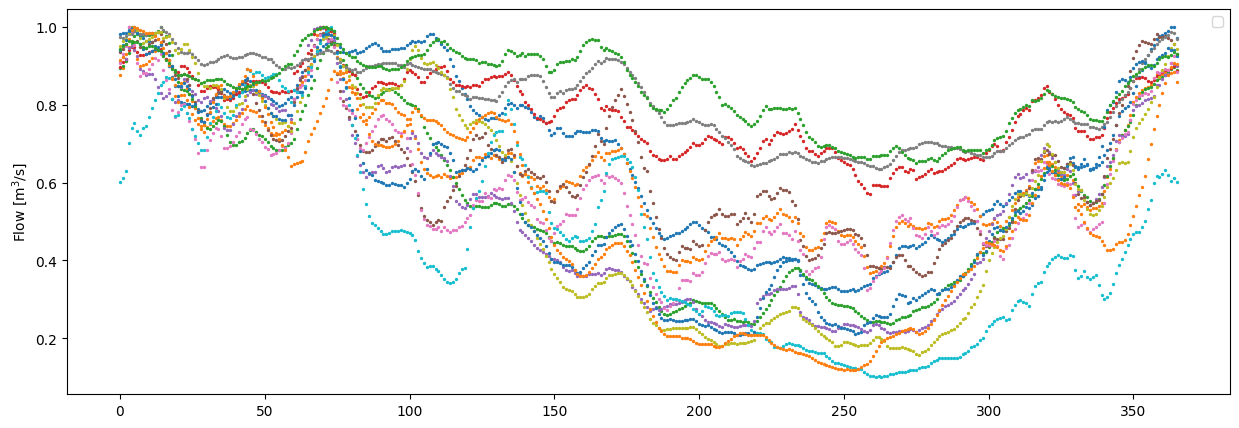

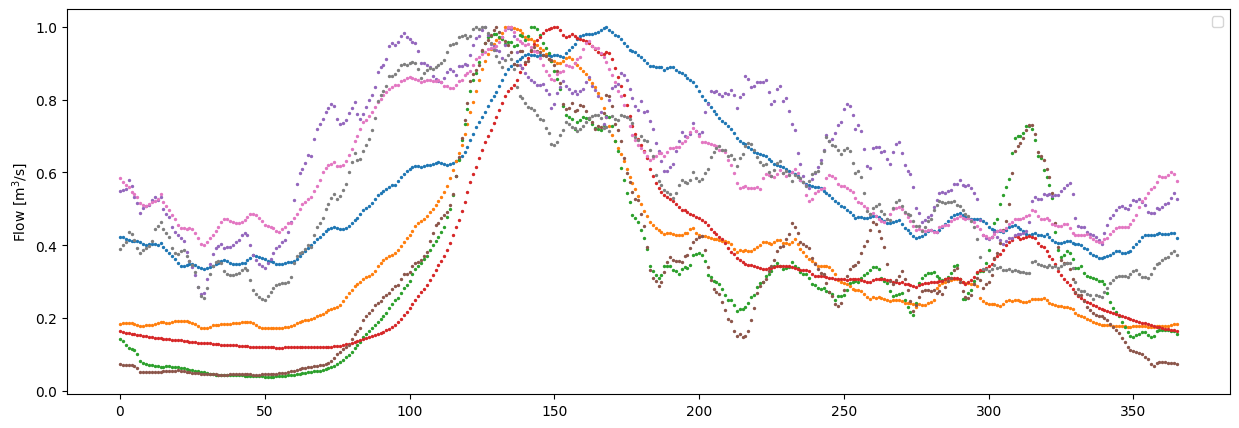

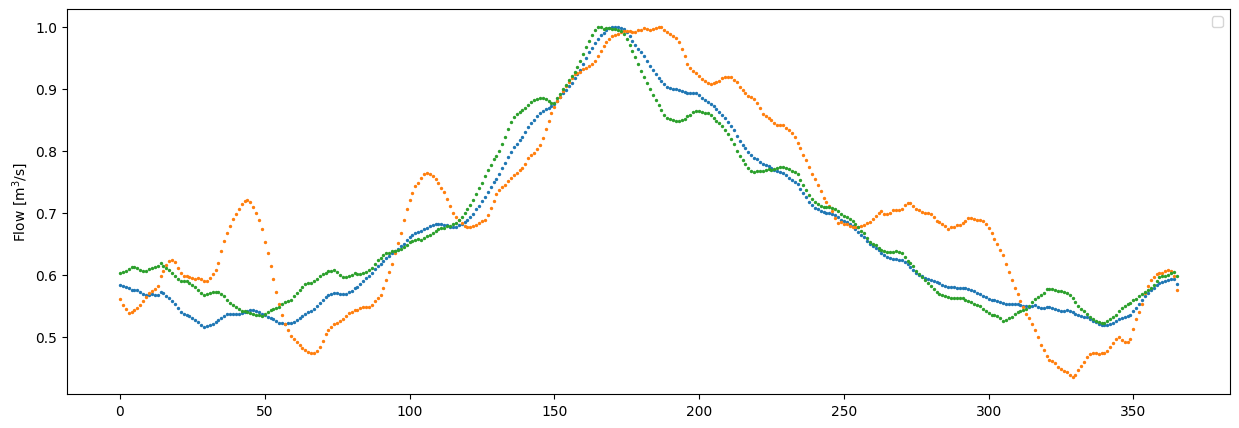

In [10]:
# plot all the stations flow data belonging to one cluster in one plot for 8 as number of cluste
import df_manipulation_functions as dfmf

num_clusters_plot = 8
flow_temp_df = pd.read_pickle("Data/flow_temp_df.pkl")

cluster_labels_kmeans_all.head()

for i in range(0,num_clusters_plot):
    belonging_to_cluster = cluster_labels_kmeans_all[cluster_labels_kmeans_all[str(num_clusters_plot) + ' clusters'] == i]
    station_numbers = belonging_to_cluster['Stationsnummer']
    labels = list()
    plt.figure(figsize=(15,5))
    #set scale of y axis to be the same for all plots
    for station in station_numbers:
        station_data = dfmf.get_running_mean_df(station, 15, flow_temp_df, 'Flow_Wert')
        plt.scatter(station_data.index, station_data['Flow_Wert']/np.max(station_data['Flow_Wert']), s=2)
        station_data['mean'] = station_data['Flow_Wert'].mean()
        #plt.plot(station_data.index, station_data['mean'])
        #add to each curve the number and name of the station
    #     station_name = flow_temp_df.loc[flow_temp_df['Stationsnummer'] == station]['Stationsname'].unique()[0]
    #     labels.append(str(station)+ " " + station_name)       
    # plt.xlabel('Day of the year')
    plt.ylabel('Flow [m$^3$/s]')
    plt.legend(labels)